In [1]:
try:
    if installed:
        print('Installed')
except:
    !pip install -q gym[classic_control]
    installed = True

In [2]:
import math
import random

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from IPython import display
from IPython.display import clear_output
from matplotlib import animation

%matplotlib inline

/media/juno/research/blackbox research/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
env_id = "CartPole-v1"
env = gym.make(env_id, render_mode='rgb_array')

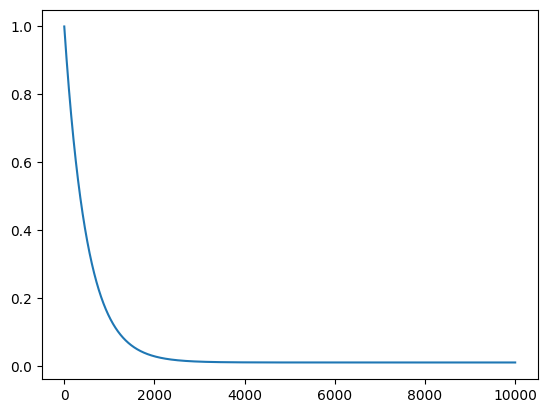

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(10000)]);

In [7]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(state).unsqueeze(0)
                state = state.to(device)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
        return action

In [8]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

model = model.to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [9]:
def compute_td_loss(batch_size, device):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.tensor(state).to(device)
    with torch.no_grad():
        next_state = torch.tensor(next_state).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    q_values      = model(state)
    next_q_values = model(next_state)
    
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [10]:
def plot(frame_idx, rewards, losses, game, game_data):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(133)
    plt.title(f'ep: {game_data[1]} step: {game_data[0]} max step: {game_data[2]}')
    plt.imshow(game)
    plt.show()

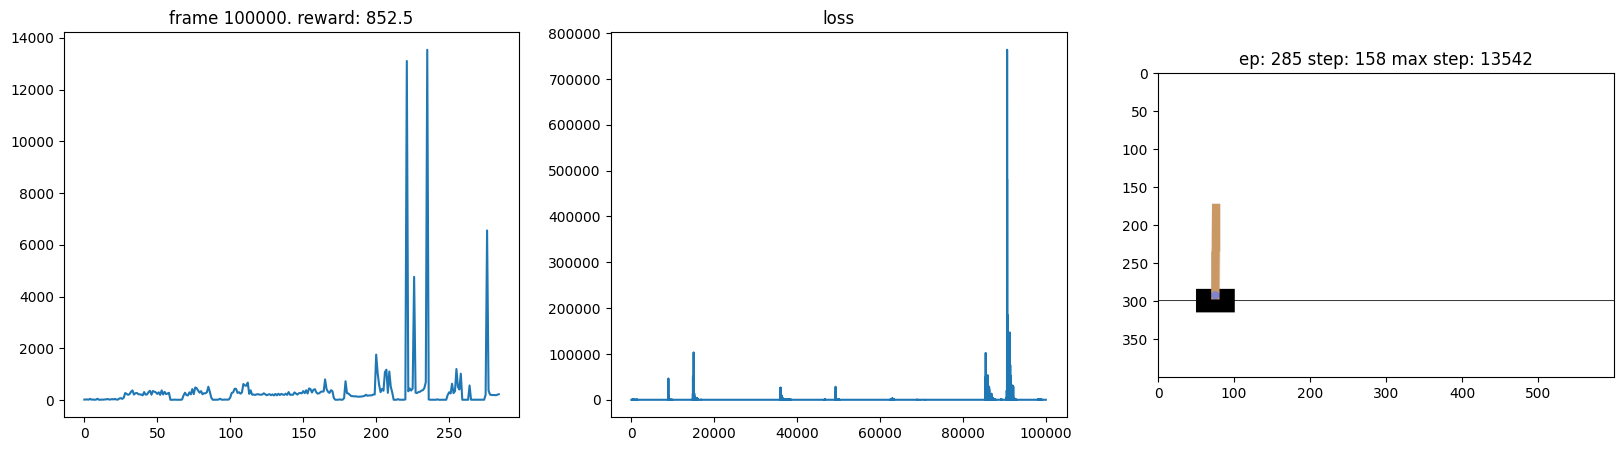

In [13]:
num_frames = 100000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
step = 0
ep = 0
max_steps = 0

state, _ = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    
    replay_buffer.push(state, action, reward, next_state, float(done))
    
    state = next_state
    episode_reward += reward
    step += 1
    max_steps = max(step, max_steps)
    
    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        step = 0
        ep += 1
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size, device)
        losses.append(loss.item())

    rgb_array = env.render();

    if frame_idx % 1000 == 0:
        plot(frame_idx, all_rewards, losses, rgb_array, (step, ep, max_steps))

In [17]:
sum(all_rewards)/len(all_rewards)

350.3228070175439

  0%|          | 0/1000 [00:00<?, ?it/s]

 20%|█▉        | 197/1000 [00:01<00:05, 135.14it/s]

KeyboardInterrupt



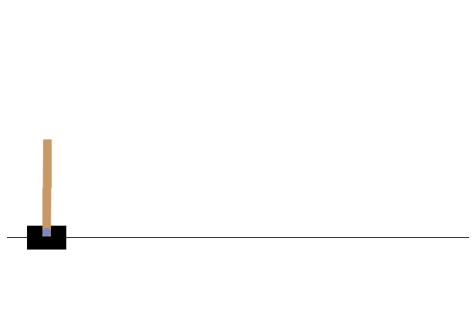

In [14]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=10)

    anim.save(path + filename, writer='imagemagick', fps=6)
    


state, _ = env.reset()
frames = []
for t in tqdm(range(1000)):
    #Render to frames buffer
    frames.append(env.render())
    action = model.act(state, epsilon)
    state, _, done, _, _ = env.step(action)
    if done:
        break

save_frames_as_gif(frames)
clear_output(wait=True)


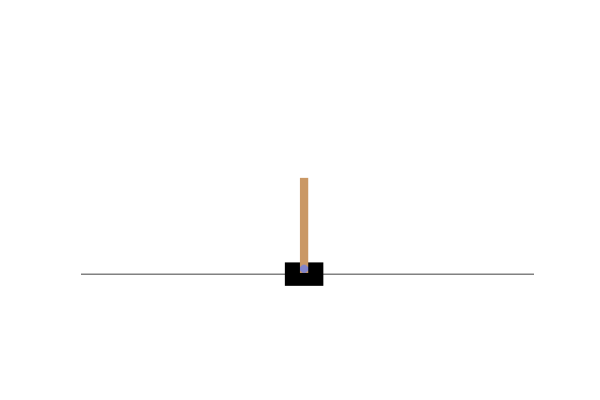

In [ ]:
gif_file = './gym_animation.gif'
import base64
from IPython.core.display import display, HTML
b64 = base64.b64encode(open(gif_file,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [18]:
torch.save(model, 'pingpong_dqn.pth')